In [1]:
import torch
from monai.networks.nets import SwinUNETR
# 
# # Initialize the model
# model = SwinUNETR(
#     img_size=(96, 96, 96),  # Input image size
#     in_channels=1,          # Number of input channels (e.g., 1 for grayscale MRI)
#     out_channels=2,         # Number of output channels (e.g., number of segmentation classes)
#     feature_size=48,        # Feature size
#     use_checkpoint=True     # Use checkpointing to save memory
# )
# 
# # Example input tensor
# input_tensor = torch.rand(1, 1, 96, 96, 96)  # Batch size 1, 1 channel, 96x96x96 volume
# 
# # Forward pass
# output = model(input_tensor)
# print(output.shape)  # Output tensor shape
from help_func import print_var_detail

C:\Users\limengyu\AppData\Local\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
import numpy as np

def get_3d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: tuple of (grid_d, grid_h, grid_w) representing depth, height, width of the grid
    return:
    pos_embed: [grid_d*grid_h*grid_w, embed_dim] or [1+grid_d*grid_h*grid_w, embed_dim] (w/ or w/o cls_token)
    """
    grid_d = np.arange(grid_size[0], dtype=np.float32)
    grid_h = np.arange(grid_size[1], dtype=np.float32)
    grid_w = np.arange(grid_size[2], dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h, grid_d, indexing='ij')  # w, h, d indexing
    grid = np.stack(grid, axis=0)  # (3, grid_d, grid_h, grid_w)

    grid = grid.reshape([3, -1])  # Flatten to (3, grid_d * grid_h * grid_w)
    
    
    
    pos_embed = get_3d_sincos_pos_embed_from_grid(embed_dim, grid)
    
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_3d_sincos_pos_embed_from_grid(embed_dim, grid):
    """
    embed_dim: Total embedding dimension
    grid: flattened grid of shape (3, grid_d * grid_h * grid_w)
    """

    assert embed_dim % 3 == 0  # Divide embedding equally among depth, height, and width
    emb_d = get_1d_sincos_pos_embed_from_grid(embed_dim // 3, grid[0])  # Encode depth
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 3, grid[1])  # Encode height
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 3, grid[2])  # Encode width

    emb = np.concatenate([emb_d, emb_h, emb_w], axis=1)  # Combine depth, height, and width embeddings
    return emb

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)
    pos = pos.reshape(-1)  # (M,)
    
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product
    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

In [3]:
import torch
import torch.nn as nn
from monai.networks.blocks import PatchEmbed
from timm.models.vision_transformer import Block

class MaskedAutoencoder3D(nn.Module):
    """Masked Autoencoder with 3D Vision Transformer backbone."""
    def __init__(self, vol_size=(128, 128, 128), patch_size=16, in_chans=1,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()
        self.in_chans = in_chans
        self.patch_size = patch_size
        self.norm_pix_loss = norm_pix_loss
        self.vol_size = vol_size
        self.patch_size= patch_size

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = PatchEmbed(
            patch_size=(patch_size, patch_size, patch_size),
            in_chans=in_chans,
            embed_dim=embed_dim,
            spatial_dims=3,
            norm_layer=norm_layer
        )

        num_patches = (vol_size[0] // patch_size) * (vol_size[1] // patch_size) * (vol_size[2] // patch_size)
        self.num_patches = num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(decoder_depth)])
        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size ** 3 * in_chans, bias=True)  # decoder to patch

        self.initialize_weights()

    def initialize_weights(self):
        grid_size = (
        self.vol_size[0] // self.patch_size,  # Number of patches along Depth
        self.vol_size[1] // self.patch_size,  # Number of patches along Height
        self.vol_size[2] // self.patch_size,  # Number of patches along Width
        )
        pos_embed = get_3d_sincos_pos_embed(self.pos_embed.shape[-1], grid_size, cls_token=True)
        print(pos_embed.shape)
        print(self.pos_embed.data.shape)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_3d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], grid_size, cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking.
        """
        N, L, D = x.shape
        len_keep = int(L * (1 - mask_ratio))
        noise = torch.rand(N, L, device=x.device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).expand(-1, -1, D))

        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        mask = torch.gather(mask, dim=1, index=ids_restore)
        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        print_var_detail(x, 'x0')
        x = self.patch_embed(x).flatten(2).transpose(1, 2)  # Flatten and transpose
        print_var_detail(x, 'x1')
        print_var_detail(self.pos_embed[:, 1:, :], 'self.pos_embed[:, 1:, :]')
        x = x + self.pos_embed[:, 1:, :]
        x, mask, ids_restore = self.random_masking(x, mask_ratio)
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        x = self.decoder_embed(x)
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_unmasked = torch.cat([x[:, 1:, :], mask_tokens], dim=1)
        x_unmasked = torch.gather(x_unmasked, dim=1, index=ids_restore.unsqueeze(-1).expand(-1, -1, x.shape[2]))
        x = torch.cat([x[:, :1, :], x_unmasked], dim=1)
        x = x + self.decoder_pos_embed

        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)
        x = self.decoder_pred(x)
        return x[:, 1:, :]

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: (B, C, D, H, W)
        pred: (B, num_patches, patch_size^3 * C)
        mask: (B, num_patches), 0 is keep, 1 is remove
        """
        target = self.patchify(imgs)  # Convert original images to patch format
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6) ** 0.5
    
        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # Mean over patch dimensions
        return (loss * mask).sum() / mask.sum()  # Weighted mean over masked patches


    def forward(self, imgs, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask
    
    def patchify(self, imgs):
        """
        Break a 3D volume into non-overlapping patches.
        Args:
            imgs (torch.Tensor): Input tensor of shape (B, C, D, H, W).
        Returns:
            torch.Tensor: Flattened patches of shape (B, num_patches, patch_size^3 * C).
        """
        p = self.patch_size  # Patch size (assumed isotropic for simplicity)
        assert imgs.shape[2] % p == 0 and imgs.shape[3] % p == 0 and imgs.shape[4] % p == 0, \
            f"Volume dimensions {imgs.shape[2:]} must be divisible by patch size {p}"
    
        # Reshape and permute to create patches
        d, h, w = imgs.shape[2] // p, imgs.shape[3] // p, imgs.shape[4] // p
        x = imgs.reshape(imgs.shape[0], imgs.shape[1], d, p, h, p, w, p)
        x = x.permute(0, 2, 4, 6, 1, 3, 5, 7).contiguous()  # (B, D, H, W, C, p, p, p)
        x = x.reshape(imgs.shape[0], d * h * w, p ** 3 * imgs.shape[1])  # Flatten patches
        return x

    def unpatchify(self, x):
        """
        Reconstruct the 3D volume from flattened patches.
        Args:
            x (torch.Tensor): Flattened patches of shape (B, num_patches, patch_size^3 * C).
        Returns:
            torch.Tensor: Reconstructed volume of shape (B, C, D, H, W).
        """
        p = self.patch_size  # Patch size (assumed isotropic for simplicity)
        d = h = w = cubic_root(x.shape[1])  # Number of patches along each dimension
        print_var_detail(x,'xx')
        print(d)
        assert d * h * w == x.shape[1], "Number of patches does not form a cube"
        
        c = x.shape[2] // (p ** 3)  # Derive the number of channels from the flattened patch size
        
        # Reshape patches back to structured volume
        x = x.reshape(x.shape[0], d, h, w, c, p, p, p)  # (B, D, H, W, C, p, p, p)
        x = x.permute(0, 4, 1, 5, 2, 6, 3, 7).contiguous()  # Rearrange dimensions to (B, C, D*p, H*p, W*p)
        x = x.reshape(x.shape[0], c, d * p, h * p, w * p)  # Merge patch dimensions
        return x


def cubic_root(n):
    """
    Compute the integer cubic root of a perfect cube.
    Args:
        n (int): The input number (must be a perfect cube).
    Returns:
        int: The integer cubic root of n.
    """
    root = round(n ** (1 / 3))  # Compute the approximate cubic root
    if root ** 3 != n:  # Verify the result
        raise ValueError(f"The input {n} is not a perfect cube.")
    return root


In [4]:
cubic_root(1728)

12

In [5]:
# Instantiate the model
model = MaskedAutoencoder3D(vol_size=(256, 256, 256), patch_size=16, in_chans=1, embed_dim=1536, num_heads=16, decoder_embed_dim=768)




(4097, 1536)
torch.Size([1, 4097, 1536])


In [7]:
input_tensor = torch.rand(1, 1, 256, 256, 256)  # Batch size 2, channels 1, volume 128x128x128
asd = model.patch_embed(input_tensor)
print_var_detail(asd)

 is a  <class 'torch.Tensor'> with shape torch.Size([1, 1536, 16, 16, 16]) max:  tensor(4.3773, grad_fn=<MaxBackward1>) min:  tensor(-4.3615, grad_fn=<MinBackward1>)


In [ ]:
# Input 3D MRI volume

loss, pred, mask = model(input_tensor, mask_ratio=0.75)

# Reconstruct volume
reconstructed_volume = model.unpatchify(pred)
print(f"Loss: {loss.item()}, Pred Shape: {pred.shape}, Reconstructed Volume Shape: {reconstructed_volume.shape}")

In [100]:
print_var_detail(mask)

 is a  <class 'torch.Tensor'> with shape torch.Size([1, 4096]) max:  tensor(1.) min:  tensor(0.)


In [101]:
def reshape_mask(mask, vol_size, patch_size):
    """
    Reshape the mask to match the 3D volume grid.
    Args:
        mask (torch.Tensor): Mask of shape (B, num_patches).
        vol_size (tuple): Original MRI volume size (D, H, W).
        patch_size (int): Patch size for each dimension.
    Returns:
        torch.Tensor: Mask reshaped to 3D grid (B, D, H, W).
    """
    B, num_patches = mask.shape
    D, H, W = vol_size[0] // patch_size, vol_size[1] // patch_size, vol_size[2] // patch_size

    # Reshape to 3D grid
    mask_3d = mask.reshape(B, D, H, W)
    return mask_3d
# mask_3d = reshape_mask(mask, (256, 256, 256), 16)
mask_3d = mask.unsqueeze(-1).repeat(1, 1, model.in_chans * model.patch_size ** 3)
mask_3d = model.unpatchify(mask_3d)
print_var_detail(mask_3d)

xx is a  <class 'torch.Tensor'> with shape torch.Size([1, 4096, 4096]) max:  tensor(1.) min:  tensor(0.)
16
 is a  <class 'torch.Tensor'> with shape torch.Size([1, 1, 256, 256, 256]) max:  tensor(1.) min:  tensor(0.)


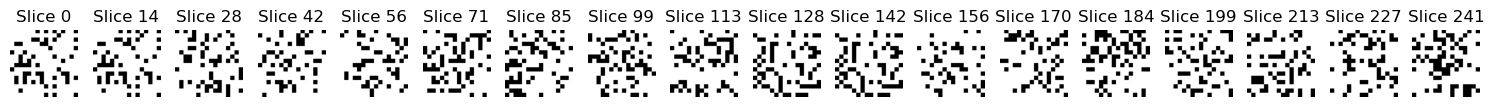

In [107]:
import matplotlib.pyplot as plt

def display_3d_mask(mask_3d, num_slices=6):
    """
    Display slices of a 3D mask using matplotlib.
    Args:
        mask_3d (torch.Tensor): 3D mask tensor of shape (D, H, W).
        num_slices (int): Number of slices to display along the depth dimension.
    """
    mask_3d = mask_3d.squeeze(0).cpu().numpy()  # Remove batch dimension and convert to numpy
    D = mask_3d.shape[0]  # Depth of the volume

    # Determine slice indices to display
    slice_indices = [int(i * D / num_slices) for i in range(num_slices)]

    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(mask_3d[slice_indices[i]], cmap="gray")
        ax.axis("off")
        ax.set_title(f"Slice {slice_indices[i]}")

    plt.tight_layout()
    plt.show()


# Display the 3D mask
display_3d_mask(mask_3d[0], num_slices=18)


In [9]:

# Test input
input_tensor = torch.rand(1, 1, 128, 128, 128)  # Batch size 2, channels 1, volume 128x128x128
output = model(input_tensor)
print(f"Output shape: {output.shape}")

TypeError: TransformerDecoderLayer.forward() missing 1 required positional argument: 'memory'

In [28]:
model

MaskedAutoencoder3D(
  (encoder_embed): PatchEmbed(
    (proj): Conv3d(1, 96, kernel_size=(4, 4, 4), stride=(4, 4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (blocks): ModuleList(
    (0): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
        (linear1): Linear(in_features=96, out_features=384, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=384, out_features=96, bias=True)
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (1): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDy

In [29]:
# Calculate model size
model_size = sum(p.numel() for p in model.parameters()) * 4 / (1024 ** 2)  # Size in MB
print(f"Model size: {model_size:.2f} MB")

Model size: 230.38 MB


In [30]:
# Test input
input_tensor = torch.rand(2, 1, 128, 128, 128)  # Batch size 2, channels 1
loss, pred, mask = model(input_tensor, mask_ratio=0.75)

print(f"Loss: {loss.item()}, Prediction Shape: {pred.shape}")

AttributeError: 'MaskedAutoencoder3D' object has no attribute 'random_masking'